In [371]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/KXBTCD-25MAY1400.csv', delimiter=',')

In [372]:
data.head()

,timestamp,product,price,strike,expiration_time,bid_1_price,bid_1_quantity,bid_2_price,bid_2_quantity,bid_3_price,...,ask_1_price,ask_1_quantity,ask_2_price,ask_2_quantity,ask_3_price,ask_3_quantity,ask_4_price,ask_4_quantity,ask_5_price,ask_5_quantity
0,2025-05-14 03:01:39,BRTI,103754.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-05-14 03:01:39,KXBTCD-25MAY1400-T103749.99,NaN,103750.0,2025-05-14 04:05:00+00:00,47.0,523.0,46.0,30.0,43.0,...,56.0,13.0,59.0,30.0,78.0,9.0,79.0,2600.0,80.0,200.0
2,2025-05-14 03:01:39,KXBTCD-25MAY1400-T103499.99,NaN,103500.0,2025-05-14 04:05:00+00:00,77.0,579.0,76.0,30.0,72.0,...,84.0,14.0,89.0,630.0,92.0,22250.0,93.0,4628.0,97.0,80000.0
3,2025-05-14 03:01:39,KXBTCD-25MAY1400-T102499.99,NaN,102500.0,2025-05-14 04:05:00+00:00,84.0,3000.0,71.0,2600.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-05-14 03:01:39,KXBTCD-25MAY1400-T102999.99,NaN,103000.0,2025-05-14 04:05:00+00:00,83.0,3000.0,61.0,2600.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [373]:
import matplotlib.pyplot as plt
import datetime

In [374]:
datetime.datetime.fromisoformat('2025-05-14 02:03:15')

datetime.datetime(2025, 5, 14, 2, 3, 15)

In [423]:
brti_prices = data[data['product'] == 'BRTI'][['timestamp', 'price']]

brti_prices.reset_index(drop=True, inplace=True)

brti_prices['timestamp'] = brti_prices.apply(lambda x: datetime.datetime.fromisoformat(x['timestamp']), axis=1)
brti_prices['timestamp'] = brti_prices['timestamp'].dt.tz_localize('UTC')


start_time = brti_prices['timestamp'].min()

# turn timestamp into seconds from start_time
brti_prices['seconds'] = brti_prices['timestamp'].apply(lambda x: (x - start_time).total_seconds()).bfill()
# convert to seconds

brti_prices['60s simple average'] = brti_prices['price'].rolling(60).mean().bfill()

window_size = 60

brti_prices['log_returns'] = pd.Series(np.log(brti_prices['price'])).diff()
brti_prices['vol_per_second'] = brti_prices['log_returns'].rolling(window_size).std().bfill()
brti_prices

,timestamp,price,seconds,60s simple average,log_returns,vol_per_second
0,2025-05-14 03:01:39+00:00,103754.47,0.0,103720.467000,NaN,0.000046
1,2025-05-14 03:01:40+00:00,103756.77,1.0,103720.467000,2.216747e-05,0.000046
2,2025-05-14 03:01:41+00:00,103754.31,2.0,103720.467000,-2.370958e-05,0.000046
3,2025-05-14 03:01:43+00:00,103754.77,4.0,103720.467000,4.433541e-06,0.000046
4,2025-05-14 03:01:44+00:00,103754.14,5.0,103720.467000,-6.072028e-06,0.000046
...,...,...,...,...,...,...
3281,2025-05-14 03:59:47+00:00,103578.20,3488.0,103576.884000,-6.371977e-06,0.000013
3282,2025-05-14 03:59:48+00:00,103577.96,3489.0,103576.951000,-2.317093e-06,0.000013
3283,2025-05-14 03:59:49+00:00,103578.05,3490.0,103577.019833,8.689103e-07,0.000013
3284,2025-05-14 03:59:50+00:00,103578.74,3491.0,103577.108167,6.661621e-06,0.000013


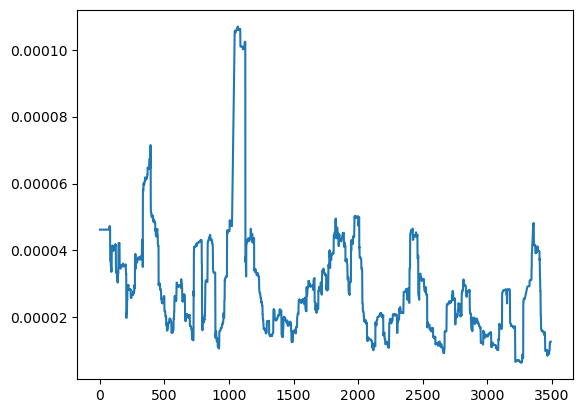

In [376]:
plt.plot(brti_prices['seconds'], brti_prices['vol_per_second'])

# GBM modelling

In [424]:
def gbm_model(price, sigma, start, end, mu=0.0, M=1000, strikes=[]):
    n = int(end-start)

    P0 = price 
    dt = 1

    sigma = 0.45 # per year
    sigma = sigma / np.sqrt(365 * 24 * 60 * 60) # per second

    # sim using np 
    St = np.exp(
        (mu - 0.5 * sigma ** 2) * dt 
        + sigma * np.sqrt(dt) * 
        np.random.normal(0, 1, (M, n)).T
    )

    # include array of 1's
    St = np.vstack([np.ones(M), St])

    # multiply through by S0 and return the cumulative product of elements along a given sim path (axis=0)
    St = P0 * np.cumprod(St, axis=0)
    St.shape

    # get last 60 seconds of each sim
    last_60 = St[-60:, :]

    # take mean of last 60 seconds of each sim
    mean_last_60 = np.mean(last_60, axis=0)

    probs = []
    for strike in strikes:
        count = np.sum(mean_last_60 > strike)
        # calculate probability
        prob = count / M
        probs.append(prob)

    return probs

In [389]:
from tqdm import tqdm

end = brti_prices['seconds'].max()
strikes = data['strike'].unique()[1:]


preds = []
# probabilities for each strike, per timestep

for row in tqdm(brti_prices.iterrows()):
    price = row[1]['price']
    sigma = row[1]['vol_per_second']
    start = row[1]['seconds']
    timestamp = row[1]['timestamp']

    pred = gbm_model(price, sigma, start, end, mu=0.0, M=1000, strikes=strikes)
    preds.append(pred)

3286it [10:01,  5.46it/s] 


In [466]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

def binary_call_price(S, K, T, r, sigma):
    d2 = (np.log(S / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return np.exp(-r * T) * norm.cdf(d2)

def implied_vol_binary_call(S, K, T, r, market_price):
    def objective(sigma):
        return binary_call_price(S, K, T, r, sigma) - market_price

    try:
        iv = brentq(objective, 1e-8, 5.0)
        return iv
    except ValueError:
        return np.nan  # No solution in range


C:\Users\chris\AppData\Local\Temp\ipykernel_29092\4259551504.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  d2 = (np.log(S / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


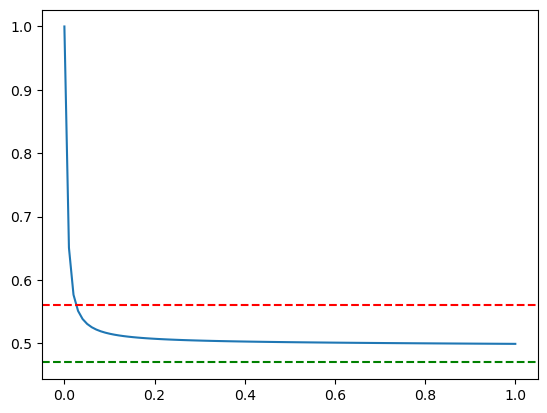

In [511]:
S = 103754.47
K = 103750
tte = 0.000121

market_price = 0.5


prices = []
for sigma in np.linspace(0, 1, 100):
    price = binary_call_price(S, K, tte, 0, sigma)
    prices.append(price)

plt.plot(np.linspace(0, 1, 100), prices)
plt.axhline(y=0.56, color='r', linestyle='--')
plt.axhline(y=0.47, color='g', linestyle='--')

In [643]:
strike = 103750.0

strike_data = data[data['strike'] > 0]
# strike_data = data[data['strike'] == strike]

brti_price_data = brti_prices[['timestamp', 'price']]

strike_data.reset_index(drop=True, inplace=True)
strike_data['timestamp'] = strike_data.apply(lambda x: datetime.datetime.fromisoformat(x['timestamp']), axis=1)
strike_data['timestamp'] = strike_data['timestamp'].dt.tz_localize('UTC')
strike_data['expiration_time'] = strike_data.apply(lambda x: datetime.datetime.fromisoformat(x['expiration_time']), axis=1)
strike_data['seconds'] = strike_data['timestamp'].apply(lambda x: (x - start_time).total_seconds()).bfill()
strike_data['tte'] = strike_data.apply(lambda x: (x['expiration_time'] - x['timestamp']).total_seconds() / 60 / 60 / 24 / 365, axis=1)

# merge with brti_price data on timestamp
strike_data = pd.merge(strike_data, brti_price_data, on='timestamp', how='left')
strike_data['spot'] = strike_data['price_y']

clean_strike_data = strike_data[['timestamp', 'spot', 'strike', 'tte', 'bid_1_price', 'ask_1_price']]
clean_strike_data['bid_1_price'] = clean_strike_data['bid_1_price'].values / 100
clean_strike_data['ask_1_price'] = clean_strike_data['ask_1_price'].values / 100

clean_strike_data['bid_iv'] = clean_strike_data.apply(
    lambda x: implied_vol_binary_call(
        S=x['spot'],
        K=x['strike'],
        T=x['tte'],
        r=0.0,
        market_price=x['bid_1_price']
    ),
    axis=1
)

clean_strike_data['ask_iv'] = clean_strike_data.apply(
    lambda x: implied_vol_binary_call(
        S=x['spot'],
        K=x['strike'],
        T=x['tte'],
        r=0.0,
        market_price=x['ask_1_price']
    ),
    axis=1
)

clean_strike_data['log_moneyness'] = pd.Series(np.log(clean_strike_data['spot'] / clean_strike_data['strike']) / np.sqrt(clean_strike_data['tte']))


C:\Users\chris\AppData\Local\Temp\ipykernel_29092\2481011380.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strike_data['timestamp'] = strike_data.apply(lambda x: datetime.datetime.fromisoformat(x['timestamp']), axis=1)
C:\Users\chris\AppData\Local\Temp\ipykernel_29092\2481011380.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strike_data['timestamp'] = strike_data['timestamp'].dt.tz_localize('UTC')
C:\Users\chris\AppData\Local\Temp\ipykernel_29092\2481011380.py:11: SettingWithCopyWarning: 
A valu

In [639]:
clean_strike_data.head()

,timestamp,spot,strike,tte,bid_1_price,ask_1_price,bid_iv,ask_iv,log_moneyness
0,2025-05-14 03:01:39+00:00,103754.47,103750.0,0.000121,0.47,0.56,NaN,0.025970,0.000043
1,2025-05-14 03:01:39+00:00,103754.47,103500.0,0.000121,0.77,0.84,0.302057,0.224643,0.002456
2,2025-05-14 03:01:39+00:00,103754.47,102500.0,0.000121,0.84,NaN,1.107423,NaN,0.012164
3,2025-05-14 03:01:39+00:00,103754.47,103000.0,0.000121,0.83,NaN,0.693936,NaN,0.007298
4,2025-05-14 03:01:39+00:00,103754.47,103250.0,0.000121,0.88,0.99,0.377175,0.190753,0.004874


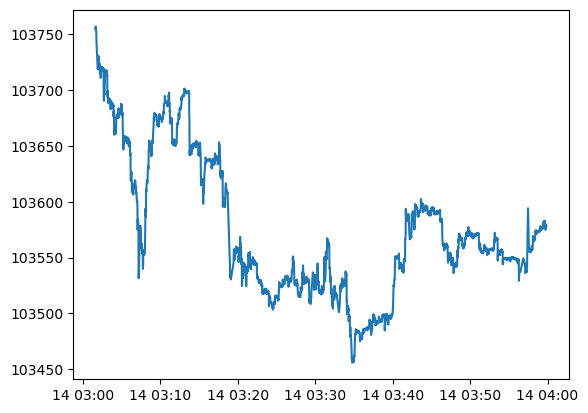

In [656]:
plt.plot(brti_prices['timestamp'], brti_prices['price'])

Text(0, 0.5, 'Implied Volatility')

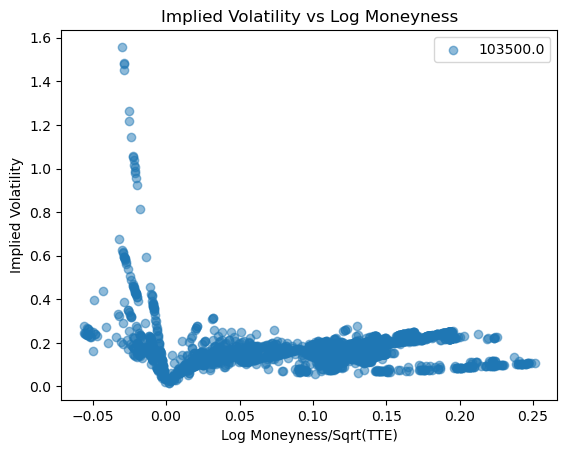

In [655]:
for strike in clean_strike_data['strike'].unique():

    if strike != 103500.0:
        continue
    
    tmp_df = clean_strike_data[clean_strike_data['strike'] == strike]

    m_t = tmp_df['log_moneyness']
    bid_iv = tmp_df['bid_iv']
    ask_iv = tmp_df['ask_iv']

    # average them, but if one is nan use the other
    bid_iv = np.where(np.isnan(bid_iv), ask_iv, bid_iv)
    ask_iv = np.where(np.isnan(ask_iv), bid_iv, ask_iv)

    mid = (bid_iv + ask_iv) / 2
    plt.scatter(m_t, ask_iv, alpha=0.5, label=str(strike))

plt.legend()

plt.title('Implied Volatility vs Log Moneyness')
plt.xlabel('Log Moneyness/Sqrt(TTE)')
plt.ylabel('Implied Volatility')

Text(0, 0.5, 'Implied Volatility')

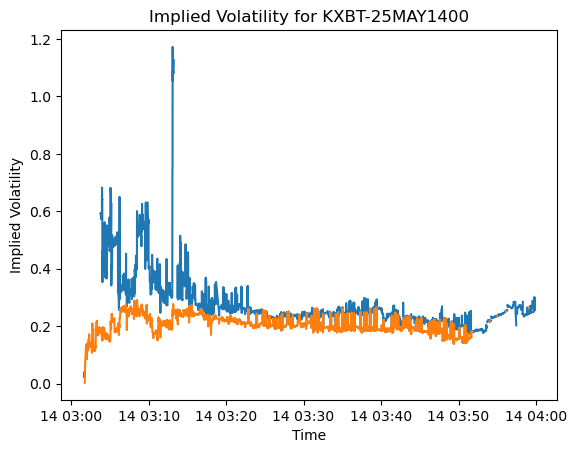

In [510]:
plt.plot(clean_strike_data['timestamp'], clean_strike_data['ask_iv'], label='Ask IV')
plt.plot(clean_strike_data['timestamp'], clean_strike_data['bid_iv'], label='Bid IV')

plt.title('Implied Volatility for KXBT-25MAY1400')
plt.xlabel('Time')
plt.ylabel('Implied Volatility')

## simulating GBM paths

In [ ]:
import numpy as np

# Assume brti_prices is your DataFrame and has 'price' as the column
log_prices = np.log(brti_prices['price'].values)
log_returns = np.diff(log_prices)

# Time delta between samples (1 second in years)
delta_t = 1 / (365 * 24 * 60 * 60)

# Annualized volatility (already given or estimated elsewhere)
# Example: sigma = 0.6
# Make sure sigma is annualized
# If you need to estimate sigma from the data:
sigma = np.std(log_returns, ddof=1) / np.sqrt(delta_t)

# Estimate drift μ (annualized)
mu = np.mean(log_returns) / delta_t + 0.5 * sigma**2

print("Estimated annualized drift (mu):", mu)
print("Estimated annualized volatility (sigma):", sigma)


Estimated annualized drift (mu): -16.284554823457846
Estimated annualized volatility (sigma): 0.18249819284273774


In [687]:
def gbm_model(price, sigma, start, end, strike, mu=0.0, M=1000):
    n = int((end-start).total_seconds())
    
    P0 = price 
    dt = 1


    sigma = sigma / np.sqrt(365 * 24 * 60 * 60) # assuming sigma is annualized
    mu = mu / np.sqrt(365 * 24 * 60 * 60) # assuming mu is annualized
    # sim using np 

    # sim using np 
    St = np.exp(
        (mu - 0.5 * sigma ** 2) * dt 
        + sigma * np.sqrt(dt) * 
        np.random.normal(0, 1, (M, n)).T
    )

    # include array of 1's
    St = np.vstack([np.ones(M), St])

    # multiply through by S0 and return the cumulative product of elements along a given sim path (axis=0)
    St = P0 * np.cumprod(St, axis=0)
    
    # get last 60 seconds of each sim
    last_60 = St[-60:, :]

    # take mean of last 60 seconds of each sim
    mean_last_60 = np.mean(last_60, axis=0)
 
    # count how many times the mean last 60 seconds is greater than the strike
    count = np.sum(mean_last_60 > strike)
    # calculate probability
    prob = count / M


    return prob

In [692]:
strike_data['prediction'] = strike_data.apply(lambda x: gbm_model(x['spot'], 0.18249819284273774, x['timestamp'], x['expiration_time'], x['strike'], mu=0), axis=1)

In [ ]:
plt.plot(strike_data['timestamp'], strike_data['prediction'] * 100, label='Probability using GBM (sigma=0.18)')
plt.plot(strike_data['timestamp'], strike_data['bid_1_price'], label='Bid Price')
plt.plot(strike_data['timestamp'], strike_data['ask_1_price'], label='Ask Price')
plt.title(f'Probability of Strike Price {strike}')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

# manual gbm modelling

In [ ]:
df = strike_data.head(1)

tte = (df['expiration_time'] - df['timestamp']).apply(lambda x: x.total_seconds())
spot = df['spot'].values[0]

dt = 1 # every second

sigma = 0.4 / np.sqrt(365 * 24 * 60 * 60)
mu = 0

# sim using np 
St = np.exp(
    (mu - 0.5 * sigma ** 2) * dt 
    + sigma * np.sqrt(dt) * 
    np.random.normal(0, 1, (M, n)).T
)

# multiply through by S0 and return the cumulative product of elements along a given sim path (axis=0)
St = P0 * np.cumprod(St, axis=0)

# get last 60 seconds of each sim
last_60 = St[-60:, :]

mean_last_60 = np.mean(last_60, axis=0)

for strike in sorted(data['strike'].unique()):
    if np.isnan(strike):
        continue
    
    # count how many times the mean last 60 seconds is greater than the strike
    count = np.sum(mean_last_60 > strike)
    # calculate probability
    prob = count / M
    print(f"Strike: {strike}, Probability: {prob*100:.2f}%")

In [594]:
# calculate each timestep
dt = 1 # every second

# sim using np 
St = np.exp(
    (mu - 0.5 * sigma ** 2) * dt 
    + sigma * np.sqrt(dt) * 
    np.random.normal(0, 1, (M, n)).T
)

# include array of 1's
St = np.vstack([np.ones(M), St])

# multiply through by S0 and return the cumulative product of elements along a given sim path (axis=0)
St = P0 * np.cumprod(St, axis=0)
St.shape

# get last 60 seconds of each sim
last_60 = St[-60:, :]

# take mean of last 60 seconds of each sim
mean_last_60 = np.mean(last_60, axis=0)

for strike in data['strike'].unique():
    if np.isnan(strike):
        continue
    
    # count how many times the mean last 60 seconds is greater than the strike
    count = np.sum(mean_last_60 > strike)
    # calculate probability
    prob = count / M
    print(f"Strike: {strike}, Probability: {prob*100:.2f}%")

Strike: 103750.0, Probability: 47.90%
Strike: 103500.0, Probability: 70.70%
Strike: 102500.0, Probability: 100.00%
Strike: 103000.0, Probability: 96.10%
Strike: 103250.0, Probability: 87.60%
Strike: 104000.0, Probability: 28.20%
Strike: 102750.0, Probability: 99.40%


Text(0, 0.5, 'Price ($)')

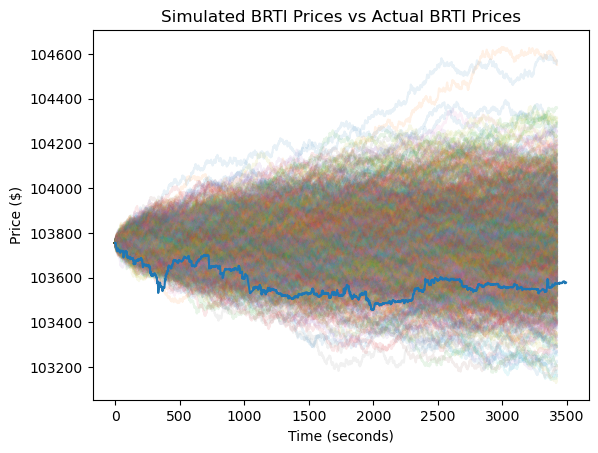

In [515]:
plt.plot(St, alpha=0.1)
plt.plot(brti_prices['seconds'], brti_prices['price'])
plt.title("Simulated BRTI Prices vs Actual BRTI Prices")
plt.xlabel("Time (seconds)")
plt.ylabel("Price ($)")